In [1]:
using StochasticDelayDiffEq
using SpecialFunctions
using Distributions
using SimulatedAnnealingABC
using Distances
using DataFrames
using FFTW
using CSV
using CairoMakie
using PairPlots
using Plots
using Statistics
using StatsBase

In [2]:
# FUNCTIONS NEDEED FOR THE MODEL

# Box-shaped function for the magnetic field range 
function f(B, B_max = 10, B_min = 1)
  return 1 / 4 * (1 .+ erf.(B .^ 2 .- B_min ^ 2)) .* (1 .- erf.(B .^ 2 .- B_max ^ 2))
end

# Drift function for the DDE
function drift(du, u, h, p, t)
  N, T, tau, sigma, Bmax = p
  lags = (T, )
  Bhist = h(p, t - lags[1])[1]
  B, dB = u

  du[1] = dB
  du[2] = - ((2 / tau) * dB + (B / tau^2) + (N / tau^2) * Bhist * f(Bhist, Bmax))
end

# Noise function for the DDE
function noise!(du, u, h, p, t)
  N, T, tau, sigma, Bmax = p
  du[1] = 0
  du[2] = (sigma * Bmax)/(tau^(3/2))
end

# DDE problem solver
function bfield(θ, Tsim, dt)
	τ, T, Nd, sigma, Bmax = θ
  lags = (T, )
	h(p, t) = [Bmax, 0.]
  B0 = [Bmax, 0.]
	tspan = (Tsim[1], Tsim[2])

	prob = SDDEProblem(drift, noise!, B0, h, tspan, θ; constant_lags = lags)
	solve(prob, EM(), dt = dt, saveat = 1.0)
end

# function for the summary statistics
function reduced_fourier_spectrum(u::Vector{Float64}, indices::Union{Vector{Int64}, StepRange{Int64, Int64}} = 1:6:120)
  fourier_transform = abs.(fft(u))
  return fourier_transform[indices]
end

# Function to plot the fourier spectrum of simulated data
function plot_fourier_spectrum(t::Vector{Float64}, u::Vector{Float64})
  Fs = 1 / (t[2] - t[1])
  N = length(u)
  freqs = fftfreq(N, Fs)

  fourier_transform_sim = abs.(fft(u))

  frequencies = freqs[(freqs .>= 0) .& (freqs .<= 0.5)]
  amplitudes = abs.(fourier_transform_sim[(freqs .>= 0) .& (freqs .<= 0.5)])

  p = Plots.plot(frequencies, amplitudes, xlabel="Frequency", ylabel="Magnitude", title="Magnitude Spectrum", legend=false)
  vline!(p, [1/11], line=:dash, color=:red, label=false)
  display(p)
end

plot_fourier_spectrum (generic function with 1 method)

In [3]:
function switch_dir(i::Int64 = 1)
  curr_path = pwd()
  directory = "Simulations/Real $i"
  path = joinpath(curr_path, directory)
  
  if isdir(path)
    cd(path)
    println("Moved to: $path")
  else
    throw(ErrorException("Directory does not exist: $path"))
  end
end

switch_dir (generic function with 2 methods)

In [4]:
switch_dir(18)

Moved to: /home/ubuntu/LCP_B/Project/Simulations/Real 18


In [5]:
df = CSV.read("rho.csv", DataFrame)

df_squared = DataFrame()

# Iterate over each column and compute the square of each element
for col in names(df)
    df_squared[!, col] = df[!, col] .^ 2
end

row_sums = Vector{Float64}(undef, size(df, 1))

# Compute the sum of each row and store it in `row_sums`
for (i, row) in enumerate(eachrow(df_squared))
    row_sums[i] = sum(row)
end

# Now `row_sums` contains the sum of each row
k = 10  # Number of minimum values you want to find
new_indices = partialsortperm(row_sums, 1:k)  # Indices of the 5 smallest values
min_values = row_sums[new_indices]  # The 5 smallest values

println("Minimum values: ", min_values)
println("Indices of minimum values: ", new_indices)

param_samples = CSV.read("pop.csv", DataFrame)

best_particles = param_samples[new_indices, :]

#mean_particles = mean(param_samples, dims = 1)

Minimum values: [0.001147434947405861, 0.0014602280637734158, 0.0014949372701642772, 0.0014999942343437882, 0.0015747295663558721, 0.0017660319098959485, 0.0018115909700435063, 0.0020995948195352493, 0.0021607720234485695, 0.0022096767456421347]
Indices of minimum values: [36, 11, 831, 597, 337, 291, 810, 26, 865, 410]


Row,N_value,T_value,tau_value,sigma_value,Bmax_value
,Float64,Float64,Float64,Float64,Float64
1,1.59956,8.80852,3.59002,0.260285,10.359
2,2.4042,7.34369,4.8781,0.12538,8.1585
3,12.8791,2.87089,1.4377,0.0502497,2.96143
4,7.83177,3.06853,5.90707,0.21994,6.08187
5,1.68535,5.3004,1.75605,0.287484,8.76151
6,8.76668,3.88338,2.68412,0.287191,3.79033
7,1.3321,9.43052,0.639472,0.147945,8.19208
8,10.2779,4.82449,3.6131,0.228373,3.10774
9,2.28868,6.39985,3.97418,0.247452,8.04469


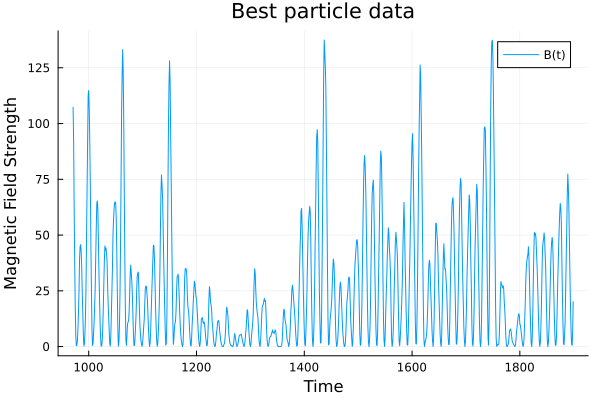

In [6]:
#par = [N, T, tau, sigma, B_max]
par = best_particles[1, :]

# Time
Tsim = [971, 1899]
dt = 0.1

# DATA SIMULATION

# Data simulation with the chosen parameter
sol = bfield(par, Tsim, dt)

# Important solution data that are necessary afterwards
t = sol.t
u = sol[1, :]
du = sol[2, :]

Plots.plot(t, u.^2, label = "B(t)", xlabel = "Time", ylabel = "Magnetic Field Strength", 
               title = "Best particle data", linewidth = 1)

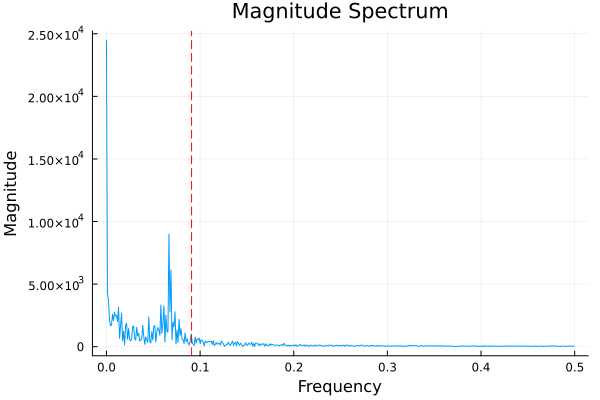

In [7]:
plot_fourier_spectrum(t, u.^2)

[1.8291511620668537, 6.28477190272251, 2.9013325602323947, 0.07705232707554699, 9.906610696168414]


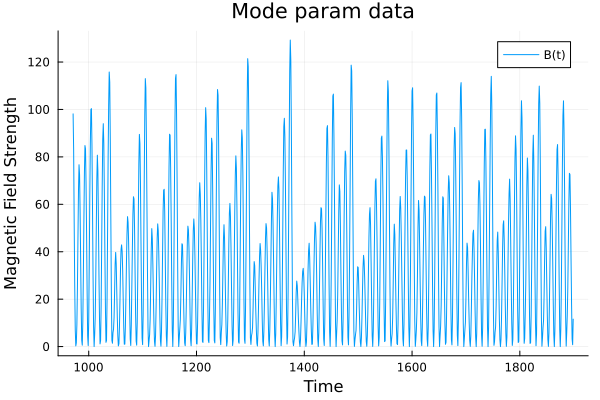

In [8]:
n_cols = size(param_samples, 2)
modes = Vector{Float64}(undef, n_cols)

# Compute mode of each column using a for loop
for col in 1:n_cols
    modes[col] = mode(param_samples[:, col])
end

println(modes)

#par = [N, T, tau, sigma, B_max]
par = modes

# Time
Tsim = [971, 1899]
dt = 0.1

# DATA SIMULATION

# Data simulation with the chosen parameter
sol = bfield(par, Tsim, dt)

# Important solution data that are necessary afterwards
t = sol.t
u = sol[1, :]
du = sol[2, :]

Plots.plot(t, u.^2, label = "B(t)", xlabel = "Time", ylabel = "Magnetic Field Strength", 
               title = "Mode param data", linewidth = 1)

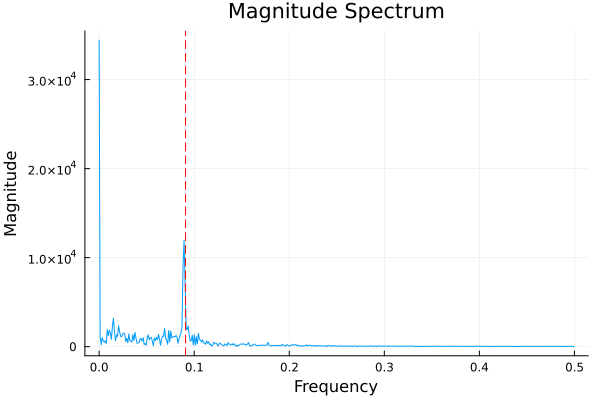

In [9]:
plot_fourier_spectrum(t, u.^2)

[5.794703780311843, 4.722437448931242, 2.865463928663157, 0.18407399377773254, 6.146575072012937]


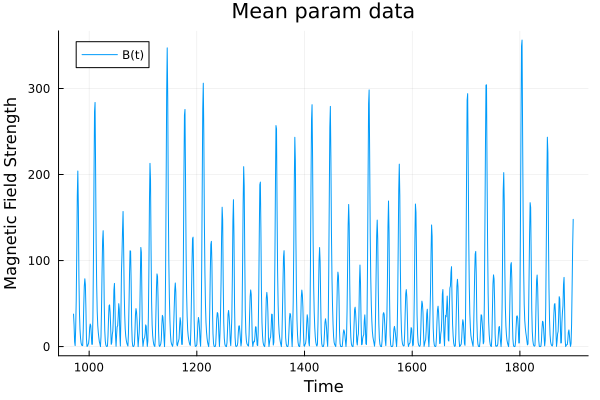

In [10]:
n_cols = size(param_samples, 2)
means = Vector{Float64}(undef, n_cols)

# Compute mode of each column using a for loop
for col in 1:n_cols
    means[col] = mean(param_samples[:, col])
end

println(means)

#par = [N, T, tau, sigma, B_max]
par = means

# Time
Tsim = [971, 1899]
dt = 0.1

# DATA SIMULATION

# Data simulation with the chosen parameter
sol = bfield(par, Tsim, dt)

# Important solution data that are necessary afterwards
t = sol.t
u = sol[1, :]
du = sol[2, :]

Plots.plot(t, u.^2, label = "B(t)", xlabel = "Time", ylabel = "Magnetic Field Strength", 
               title = "Mean param data", linewidth = 1)

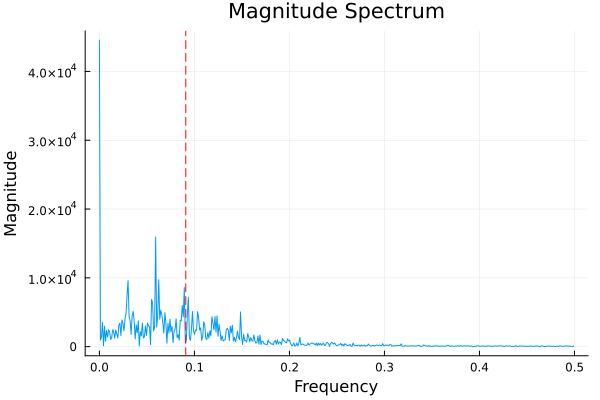

In [11]:
plot_fourier_spectrum(t, u.^2)

In [12]:
cd("/home/ubuntu/LCP_B/Project")